# Multiqudit simulator

In cold atoms, we do not necessarily work with qubits. As an example, we implemented here the operation on a single qudit as it is implemented in Heidelberg University. In this notebook we present the communication with our API. The communication with the backend happens through the four url

1. '.../multiqudit/get_config/' 
2. '.../multiqudit/post_job/'
3. '.../multiqudit/get_job_status/'
4. '.../multiqudit/get_job_result/'

# get config

Getting the description of the simulator/backend as a json file

* user login  at '.../get_config'
* json file with simulator/backend description 

In [1]:
import requests
import json
from pprint import pprint

This imports the `credentials.py` file you received from us.

In [2]:
#from heroku_credentials import username, password
from credentials import username, password

In [3]:
#url_prefix="https://qsimsim.synqs.org/multiqudit/" # the cloud back-end
url_prefix = 'http://localhost:8000/multiqudit/' # the back-end for local testing

In [4]:
url= url_prefix + "get_config/"
print(url)

r = requests.get(url,params={'username': username,'password':password})

r_dict  = json.loads(r.text)
pprint(r_dict)

http://localhost:8000/multiqudit/get_config/
{'atomic_species': ['na'],
 'backend_name': 'synqs_multi_qudit_simulator',
 'backend_version': '0.0.1',
 'basis_gates': ['rLx', 'rLz', 'rLz2', 'XY'],
 'cold_atom_type': 'spin',
 'conditional': False,
 'coupling_map': [[]],
 'credits_required': False,
 'description': 'Setup of a cold atomic gas experiment with qudits.',
 'display_name': '<Multi_Qudit',
 'gates': [{'coupling_map': [[0], [1], [2], [3], [4]],
            'description': 'Evolution under the Z gate',
            'name': 'rLz',
            'parameters': ['delta'],
            'qasm_def': 'gate rLz(delta) {}'},
           {'coupling_map': [[0], [1], [2], [3], [4]],
            'description': 'Evolution under Lz2',
            'name': 'rLz2',
            'parameters': ['chi'],
            'qasm_def': 'gate rLz2(chi) {}'},
           {'coupling_map': [[0], [1], [2], [3], [4]],
            'description': 'Evolution under Lx',
            'name': 'rLx',
            'parameters': ['omega

# The mult-qudit backend

The single qudit Hilbert space is $|l, m\rangle$ with $l = 1$ and $m = -1, 0, 1$ being an eigenstate of the total angular momentum
operator and the z-component

\begin{align}
    L^2 |l,m\rangle &= l (l+1) |l,m \rangle \notag  \\
    L_z |l, m\rangle &= m |l, m\rangle \notag
\end{align}

The Hamiltonian which controls the qudit is 

\begin{align}
    H = \chi L_z^2 + \Delta L_z + \Omega L_x
\end{align}
where the coupling constants $\chi$, $\Delta$ and $\Omega$ can be switched on and off individually.

We us the above Hamiltonian to generate the following three gates

* Rotation around the z-axis 
    \begin{align}
        Rz = \exp\{  i \theta L_z \} 
    \end{align}
* Rotation around the x-axis 
    \begin{align}
        Rx = \exp\{ i \theta L_x \} 
    \end{align} 
* Squeezing operation 
    \begin{align}
        S = \exp\{ i \theta L^2_z \} 
    \end{align}

## x rotation

This rotates the qudit around the x axis to put it into a superposition of z states. We start with a $\pi$ rotation i.e
    \begin{align}
        rLx = \exp\{ i \pi L_x \} 
    \end{align} 

In [5]:
import numpy as np
import matplotlib.pyplot as plt

In [6]:
job_payload = {
    'experiment_0': {
    'instructions': [
        ('rLx', [1], [np.pi]),
        ('measure', [0], []),
        ('measure', [1], []),
        ('measure', [2], []),
        ('measure', [3], []),
        ],
        'num_wires': 4,
        'shots': 4
    },
}

Send the job to the server

In [7]:
url= url_prefix + "post_job/" 

job_response = requests.post(url, data={'json':json.dumps(job_payload),'username': username,'password':password})
job_id = (job_response.json())['job_id']
print(job_response.text)

{"job_id": 50, "status": "INITIALIZING", "detail": "Got your json."}


Test for completion

In [8]:
status_payload = {'job_id': job_id}

url= url_prefix + "get_job_status/" 

status_response = requests.get(url, params={'json':json.dumps(status_payload),'username': username,'password':password})

print(status_response.text)

{"job_id": 50, "status": "DONE", "detail": "Got your json.; Passed json sanity check; Compilation done. Shots sent to solver"}


Obtaining results

In [9]:
result_payload = {'job_id': job_id}
url= url_prefix + "get_job_result/" 

result_response = requests.get(url, params={'json':json.dumps(result_payload),'username': username,'password':password})

r_dict  = json.loads(result_response.text)
pprint(r_dict)

{'backend_name': 'synqs_multi_qudit_simulator',
 'backend_version': '0.0.1',
 'header': {},
 'job_id': 50,
 'qobj_id': None,
 'results': [{'data': {'memory': ['0 1 0 0', '0 1 0 0', '0 1 0 0', '0 1 0 0']},
              'header': {'extra metadata': 'None', 'name': 'MultiQudit'},
              'shots': 4,
              'success': True}],
 'status': 'finished',
 'success': True}


the result of the calculation is then

In [10]:
res_dict = json.loads(result_response.text)
measurements = res_dict["results"][0]['data']['memory']
print(measurements)

['0 1 0 0', '0 1 0 0', '0 1 0 0', '0 1 0 0']


## Change number of wires

The following section tests if we can change the number of wires

In [11]:
job_payload = {
    'experiment_0': {
        'instructions': [
            ('rLx', [0], [0.7]),
            ('measure', [0], [])
        ],
        'num_wires': 1,
        'shots': 3
    },
    'experiment_1': {
        'instructions': [
            ('rLx', [1], [0.7]),
            ('measure', [0], []),
            ('measure', [1], [])
        ],
        'num_wires': 2,
        'shots': 3
    },
    'experiment_2': {
        'instructions': [
            ('rLx', [2], [0.7]),
            ('measure', [0], []),
            ('measure', [1], []),
            ('measure', [2], [])
        ],
        'num_wires': 3,
        'shots': 3
    },
    'experiment_3': {
        'instructions': [
            ('rLx', [3], [0.7]),
            ('measure', [0], []),
            ('measure', [1], []),
            ('measure', [2], []),
            ('measure', [3], [])
        ],
        'num_wires': 4,
        'shots': 3
    },
}

In [12]:
url= url_prefix + "post_job/" 

job_response = requests.post(url, data={'json':json.dumps(job_payload),'username': username,'password':password})
job_id = (job_response.json())['job_id']
print(job_response.text)

{"job_id": 51, "status": "INITIALIZING", "detail": "Got your json."}


In [13]:
status_payload = {'job_id': job_id}
url= url_prefix + "get_job_status/" 

status_response = requests.get(url, params={'json':json.dumps(status_payload),'username': username,'password':password})
print(status_response.text)

{"job_id": 51, "status": "DONE", "detail": "Got your json.; Passed json sanity check; Compilation done. Shots sent to solver"}


In [14]:
result_payload = {'job_id': job_id}
url= url_prefix + "get_job_result/" 

result_response = requests.get(url, params={'json':json.dumps(result_payload),'username': username,'password':password})
print(result_response.text)

{"backend_name": "synqs_multi_qudit_simulator", "backend_version": "0.0.1", "job_id": 51, "qobj_id": null, "success": true, "status": "finished", "header": {}, "results": [{"header": {"name": "MultiQudit", "extra metadata": "None"}, "shots": 3, "success": true, "data": {"memory": ["0", "0", "0"]}}, {"header": {"name": "MultiQudit", "extra metadata": "None"}, "shots": 3, "success": true, "data": {"memory": ["0 0", "0 1", "0 0"]}}, {"header": {"name": "MultiQudit", "extra metadata": "None"}, "shots": 3, "success": true, "data": {"memory": ["0 0 0", "0 0 0", "0 0 0"]}}, {"header": {"name": "MultiQudit", "extra metadata": "None"}, "shots": 3, "success": true, "data": {"memory": ["0 0 0 0", "0 0 0 0", "0 0 0 0"]}}]}


In [15]:
res_dict = json.loads(result_response.text)
measurements = res_dict["results"][0]['data']['memory']
print(measurements)

['0', '0', '0']


## Rabi oscillation

The following section creates a Rabi-oscillation

Create several jobs determined by the phase  

In [16]:
n_phases = 11 # number of phases we would like to investigate
phases = np.linspace(0,2*np.pi,n_phases) #array of phases
job_payload = {}

for ii in range(n_phases):
    exp_str = 'experiment_' + str(ii)
    dummy_exp = {
        'instructions': [
            ('rLx', [0], [phases[ii]]),
            ('measure', [0], []),
            ],
            'num_wires': 4,
            'shots': 12
    }
    job_payload[exp_str] = dummy_exp
pprint(job_payload)


{'experiment_0': {'instructions': [('rLx', [0], [0.0]), ('measure', [0], [])],
                  'num_wires': 4,
                  'shots': 12},
 'experiment_1': {'instructions': [('rLx', [0], [0.6283185307179586]),
                                   ('measure', [0], [])],
                  'num_wires': 4,
                  'shots': 12},
 'experiment_10': {'instructions': [('rLx', [0], [6.283185307179586]),
                                    ('measure', [0], [])],
                   'num_wires': 4,
                   'shots': 12},
 'experiment_2': {'instructions': [('rLx', [0], [1.2566370614359172]),
                                   ('measure', [0], [])],
                  'num_wires': 4,
                  'shots': 12},
 'experiment_3': {'instructions': [('rLx', [0], [1.8849555921538759]),
                                   ('measure', [0], [])],
                  'num_wires': 4,
                  'shots': 12},
 'experiment_4': {'instructions': [('rLx', [0], [2.5132741228718345]),
 

Send the job to the server via request.post(...)

In [17]:
url= url_prefix + "post_job/"

job_response = requests.post(url, data={'json':json.dumps(job_payload),'username': username,'password':password})
job_id = (job_response.json())['job_id']
print(job_response.text)

{"job_id": 52, "status": "INITIALIZING", "detail": "Got your json."}


Test if the job is completed

In [18]:
status_payload = {'job_id': job_id}

url= url_prefix + "get_job_status/"
status_response = requests.get(url, params={'json':json.dumps(status_payload),'username': username,'password':password})

print(status_response.text)

{"job_id": 52, "status": "DONE", "detail": "Got your json.; Passed json sanity check; Compilation done. Shots sent to solver"}


and obtain the results via requests.get(...)

In [19]:
result_payload = {'job_id': job_id}

url= url_prefix + "get_job_result/"
result_response = requests.get(url, params={'json':json.dumps(result_payload),'username': username,'password':password})

r_dict  = json.loads(result_response.text)
pprint(r_dict)

{'backend_name': 'synqs_multi_qudit_simulator',
 'backend_version': '0.0.1',
 'header': {},
 'job_id': 52,
 'qobj_id': None,
 'results': [{'data': {'memory': ['0',
                                  '0',
                                  '0',
                                  '0',
                                  '0',
                                  '0',
                                  '0',
                                  '0',
                                  '0',
                                  '0',
                                  '0',
                                  '0']},
              'header': {'extra metadata': 'None', 'name': 'MultiQudit'},
              'shots': 12,
              'success': True},
             {'data': {'memory': ['0',
                                  '0',
                                  '0',
                                  '0',
                                  '0',
                                  '1',
                                  '1',

The result of the calculation

In [20]:
measurements = []
for res in r_dict["results"]:
    shots = np.array(res['data']['memory'])
    shots = [shot.split(' ') for shot in shots]
    #print(shots.shape)
    for ii, el in enumerate(shots):
        shots[ii] = [int(meas) for meas in el]
    measurements.append(shots)
    
measurements = np.array(measurements)

Text(0.5, 0, '$\\phi_z$')

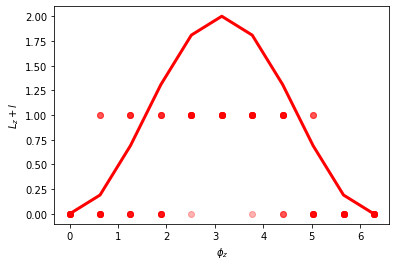

In [21]:
f, ax = plt.subplots()
ax.plot(phases, np.squeeze(np.array(measurements)), 'ro', alpha = 0.3)
ax.plot(phases, 1*(1-np.cos(phases)), 'r-', lw = 3)
ax.set_ylabel(r'$L_z + l$')
ax.set_xlabel(r'$\phi_z$')

## Ramsey cycle

The gate sequence for the Ramsey cycle is $e^{i (\pi/2) L_x} e^{i \varphi L_z} e^{i (\pi/2) L_x}$

In [22]:
n_phases = 11 # number of phases we would like to investigate
phases = np.linspace(0,2*np.pi,n_phases)
job_payload = {}

for ii in range(n_phases):
    exp_str = 'experiment_' + str(ii)
    dummy_exp = {
        'instructions': [
            ('rLx', [3], [np.pi/2]),
            ('rLz', [3], [phases[ii]]),
            ('rLx', [3], [np.pi/2]),
            ('measure', [3], []),
            ],
            'num_wires': 4,
            'shots': 5
    }
    job_payload[exp_str] = dummy_exp
pprint(job_payload)

{'experiment_0': {'instructions': [('rLx', [3], [1.5707963267948966]),
                                   ('rLz', [3], [0.0]),
                                   ('rLx', [3], [1.5707963267948966]),
                                   ('measure', [3], [])],
                  'num_wires': 4,
                  'shots': 5},
 'experiment_1': {'instructions': [('rLx', [3], [1.5707963267948966]),
                                   ('rLz', [3], [0.6283185307179586]),
                                   ('rLx', [3], [1.5707963267948966]),
                                   ('measure', [3], [])],
                  'num_wires': 4,
                  'shots': 5},
 'experiment_10': {'instructions': [('rLx', [3], [1.5707963267948966]),
                                    ('rLz', [3], [6.283185307179586]),
                                    ('rLx', [3], [1.5707963267948966]),
                                    ('measure', [3], [])],
                   'num_wires': 4,
                   'shots': 5},
 '

we first send the job to the server

In [23]:
url= url_prefix + "post_job/"

job_response = requests.post(url, data={'json':json.dumps(job_payload),'username': username,'password':password})
job_id = (job_response.json())['job_id']
print(job_response.text)

{"job_id": 53, "status": "INITIALIZING", "detail": "Got your json."}


Test for completion.

In [24]:
status_payload = {'job_id': job_id}
url= url_prefix + "get_job_status/"

status_response = requests.get(url, params={'json':json.dumps(status_payload),'username': username,'password':password})

print(status_response.text)

{"job_id": 53, "status": "DONE", "detail": "Got your json.; Passed json sanity check; Compilation done. Shots sent to solver"}


Obtaining results

In [25]:
result_payload = {'job_id': job_id}

url= url_prefix + "get_job_result/"
result_response = requests.get(url, params={'json':json.dumps(result_payload),'username': username,'password':password})

r_dict  = json.loads(result_response.text)
pprint(r_dict)

{'backend_name': 'synqs_multi_qudit_simulator',
 'backend_version': '0.0.1',
 'header': {},
 'job_id': 53,
 'qobj_id': None,
 'results': [{'data': {'memory': ['1', '1', '1', '1', '1']},
              'header': {'extra metadata': 'None', 'name': 'MultiQudit'},
              'shots': 5,
              'success': True},
             {'data': {'memory': ['1', '1', '1', '1', '1']},
              'header': {'extra metadata': 'None', 'name': 'MultiQudit'},
              'shots': 5,
              'success': True},
             {'data': {'memory': ['1', '0', '0', '0', '1']},
              'header': {'extra metadata': 'None', 'name': 'MultiQudit'},
              'shots': 5,
              'success': True},
             {'data': {'memory': ['1', '1', '0', '0', '1']},
              'header': {'extra metadata': 'None', 'name': 'MultiQudit'},
              'shots': 5,
              'success': True},
             {'data': {'memory': ['0', '0', '0', '0', '0']},
              'header': {'extra metadata':

The result of the Ramsey cycle is

In [26]:
measurements = []
for res in r_dict["results"]:
    shots = np.array(res['data']['memory'])
    shots = [shot.split(' ') for shot in shots]
    #print(shots.shape)
    for ii, el in enumerate(shots):
        shots[ii] = [int(meas) for meas in el]
    measurements.append(shots)
    
measurements = np.array(measurements)

Text(0.5, 0, '$\\phi_z$')

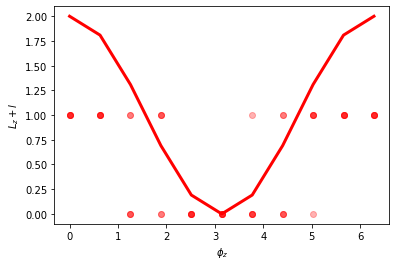

In [27]:

f, ax = plt.subplots()
ax.plot(phases, np.squeeze(np.array(measurements)), 'ro', alpha = 0.3)
ax.plot(phases, 1*(1+np.cos(phases)), 'r-', lw = 3)
ax.set_ylabel(r'$L_z + l$')
ax.set_xlabel(r'$\phi_z$')

## Local entanglement of Qudits

In [58]:
job_payload = {
    'experiment_0': {
    'instructions': [
        ('rLx', [0], [np.pi]),
        ('LxLy',  [0, 3], [np.pi/2]),
        ('measure', [0], []),
        ('measure', [1], []),
        ('measure', [3], []),
        ],
        'num_wires': 4,
        'shots': 4
    },
}

In [59]:
url= url_prefix + "post_job/" 

job_response = requests.post(url, data={'json':json.dumps(job_payload),'username': username,'password':password})
job_id = (job_response.json())['job_id']
print(job_response.text)


{"job_id": 62, "status": "INITIALIZING", "detail": "Got your json."}


In [60]:
status_payload = {'job_id': job_id}

url= url_prefix + "get_job_status/" 

status_response = requests.get(url, params={'json':json.dumps(status_payload),'username': username,'password':password})

print(status_response.text)

{"job_id": 62, "status": "DONE", "detail": "Got your json.; Passed json sanity check; Compilation done. Shots sent to solver"}


In [61]:
result_payload = {'job_id': job_id}
url= url_prefix + "get_job_result/" 

result_response = requests.get(url, params={'json':json.dumps(result_payload),'username': username,'password':password})

r_dict  = json.loads(result_response.text)
pprint(r_dict)

{'backend_name': 'synqs_multi_qudit_simulator',
 'backend_version': '0.0.1',
 'header': {},
 'job_id': 62,
 'qobj_id': None,
 'results': [{'data': {'memory': ['0 0 1', '0 0 1', '0 0 1', '0 0 1']},
              'header': {'extra metadata': 'None', 'name': 'MultiQudit'},
              'shots': 4,
              'success': True}],
 'status': 'finished',
 'success': True}


# Loading atoms into wires

Load atoms in the tweezer

In [32]:
job_payload = {
    'experiment_0': {
    'instructions': [
        ('load', [0], [1]),
        ('load', [2], [2]),
        ('load', [3], [3]),
        ('load', [1], [4]),
        ('rLx', [0], [np.pi]),
        ('measure', [0], []),
        ('measure', [3], []),
        ],
    'num_wires': 4,
    'shots': 4
    },
}

In [33]:
url= url_prefix + "post_job/" 

job_response = requests.post(url, data={'json':json.dumps(job_payload),'username': username,'password':password})
job_id = (job_response.json())['job_id']
print(job_response.text)

{"job_id": 55, "status": "INITIALIZING", "detail": "Got your json."}


In [34]:
result_payload = {'job_id': job_id}
url= url_prefix + "get_job_result/" 

result_response = requests.get(url, params={'json':json.dumps(result_payload),'username': username,'password':password})

print(result_response.text)

{"backend_name": "synqs_multi_qudit_simulator", "backend_version": "0.0.1", "job_id": 55, "qobj_id": null, "success": true, "status": "finished", "header": {}, "results": [{"header": {"name": "MultiQudit", "extra metadata": "None"}, "shots": 4, "success": true, "data": {"memory": ["0 0", "0 0", "0 0", "0 0"]}}]}


# ZZ gates into wires

Load atoms in the tweezer

In [35]:
job_payload = {
    'experiment_0': {
    'instructions': [
        ('load', [0], [1]),
        ('load', [2], [2]),
        ('load', [3], [3]),
        ('load', [1], [4]),
        ('rLx',  [0], [np.pi]),
        ('LzLz', [0, 3], [1.5]),
        ('measure', [0], []),
        ('measure', [3], []),
        ],
    'num_wires': 4,
    'shots': 4
    },
}

In [36]:
url= url_prefix + "post_job/" 

job_response = requests.post(url, data={'json':json.dumps(job_payload),'username': username,'password':password})
job_id = (job_response.json())['job_id']
print(job_response.text)

{"job_id": 56, "status": "INITIALIZING", "detail": "Got your json."}


In [37]:
result_payload = {'job_id': job_id}
url= url_prefix + "get_job_result/" 

result_response = requests.get(url, params={'json':json.dumps(result_payload),'username': username,'password':password})

print(result_response.text)

{"job_id": 56, "status": "ERROR", "detail": "Got your json.; Failed json sanity check. File will be deleted"}
